In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as db

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
from sklearn.preprocessing import MinMaxScaler
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam

from IPython.display import clear_output

In [2]:
print("CUDA available", torch.cuda.is_available())
print("CUDA dev count", torch.cuda.device_count())
print("CUDA dev curr", torch.cuda.current_device())
print("CUDA dev", torch.cuda.device(0))
print("CUDA dev name", torch.cuda.get_device_name(0))

CUDA available True
CUDA dev count 1
CUDA dev curr 0
CUDA dev <torch.cuda.device object at 0x0000018B0585BE10>
CUDA dev name NVIDIA GeForce GTX 1650


Connection to DLSU Cloud DB (PAL)
- `connection.json` is abstracted for data privacy

Reading the Historical Data

In [3]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + 'Historical')

def query_historical(table_name):
    query = f"SELECT * FROM {table_name}"
    hist = pd.read_sql(query, engine)
    hist.index = hist['index']
    hist.drop('index', axis=1, inplace=True)
    return hist

In [4]:
palb777 = query_historical('PALB777_hour')
pala321c = query_historical('PALA321C_hour')
pala333 = query_historical('PALA333_hour')
gapa321c = query_historical('GAPA321C_hour')
gapa320 = query_historical('GAPA320_hour')

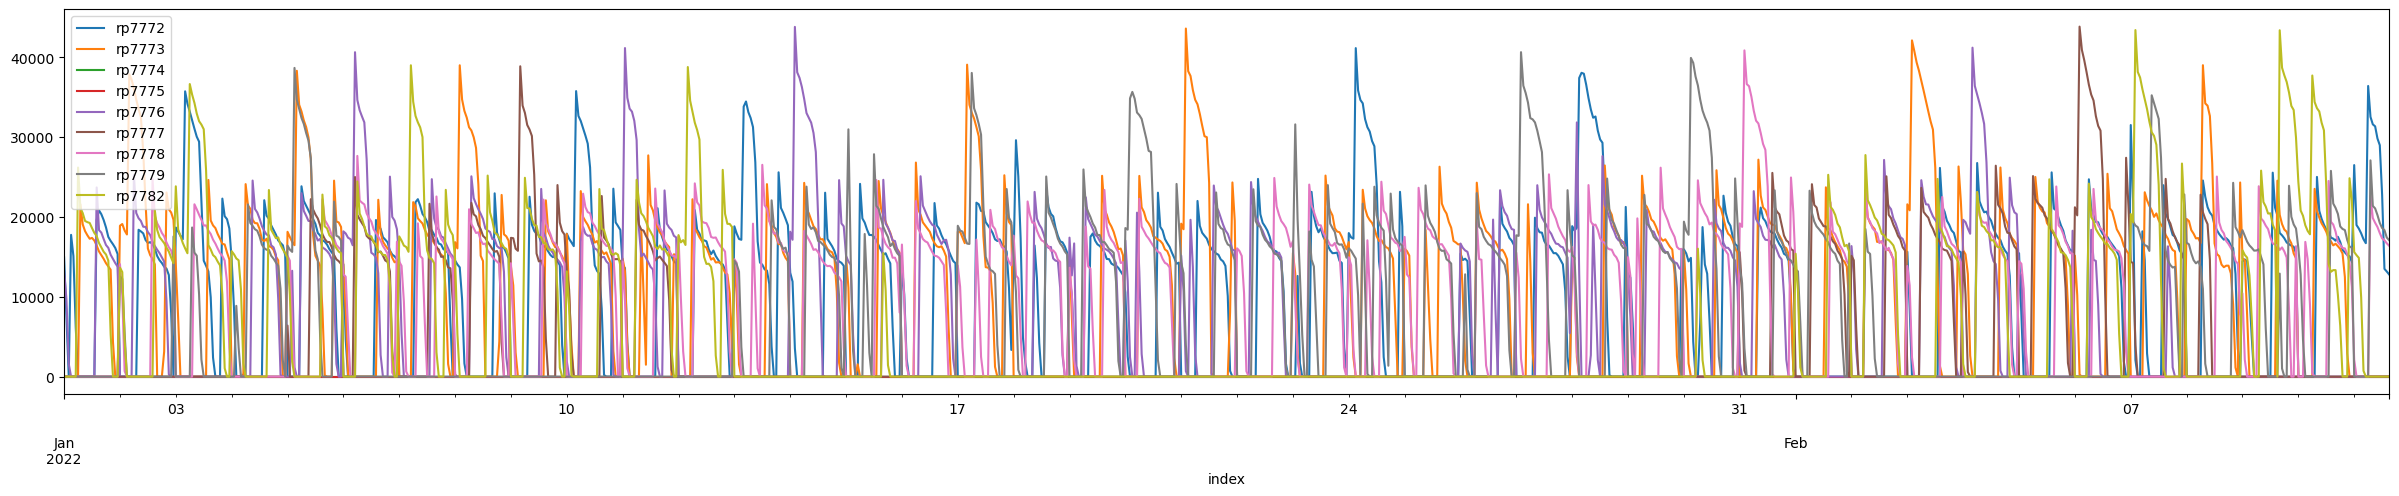

In [5]:
palb777[:1000].plot(figsize=(30,5))
plt.show()

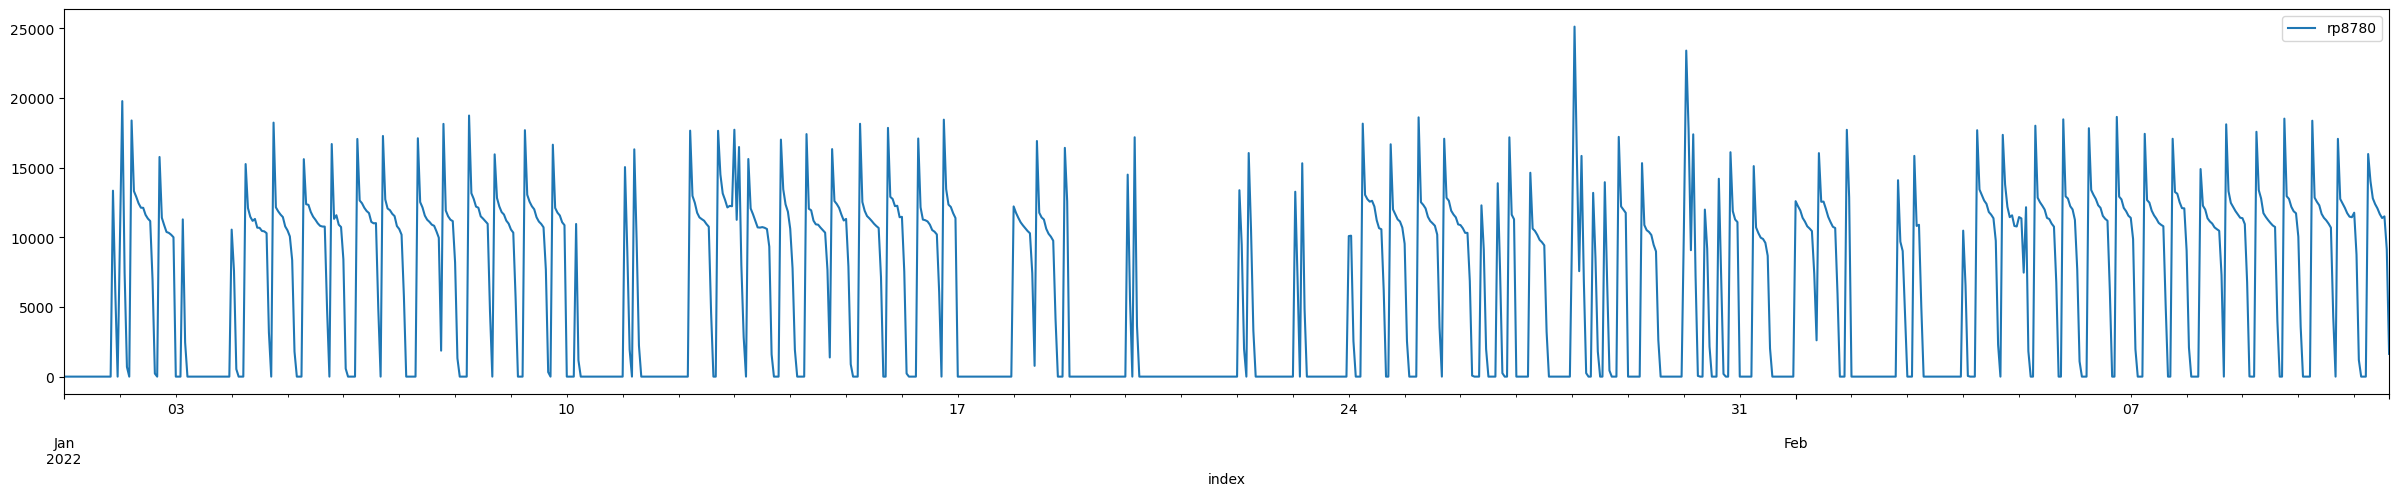

In [6]:
pala333[:1000].plot(figsize=(30,5))
plt.show()

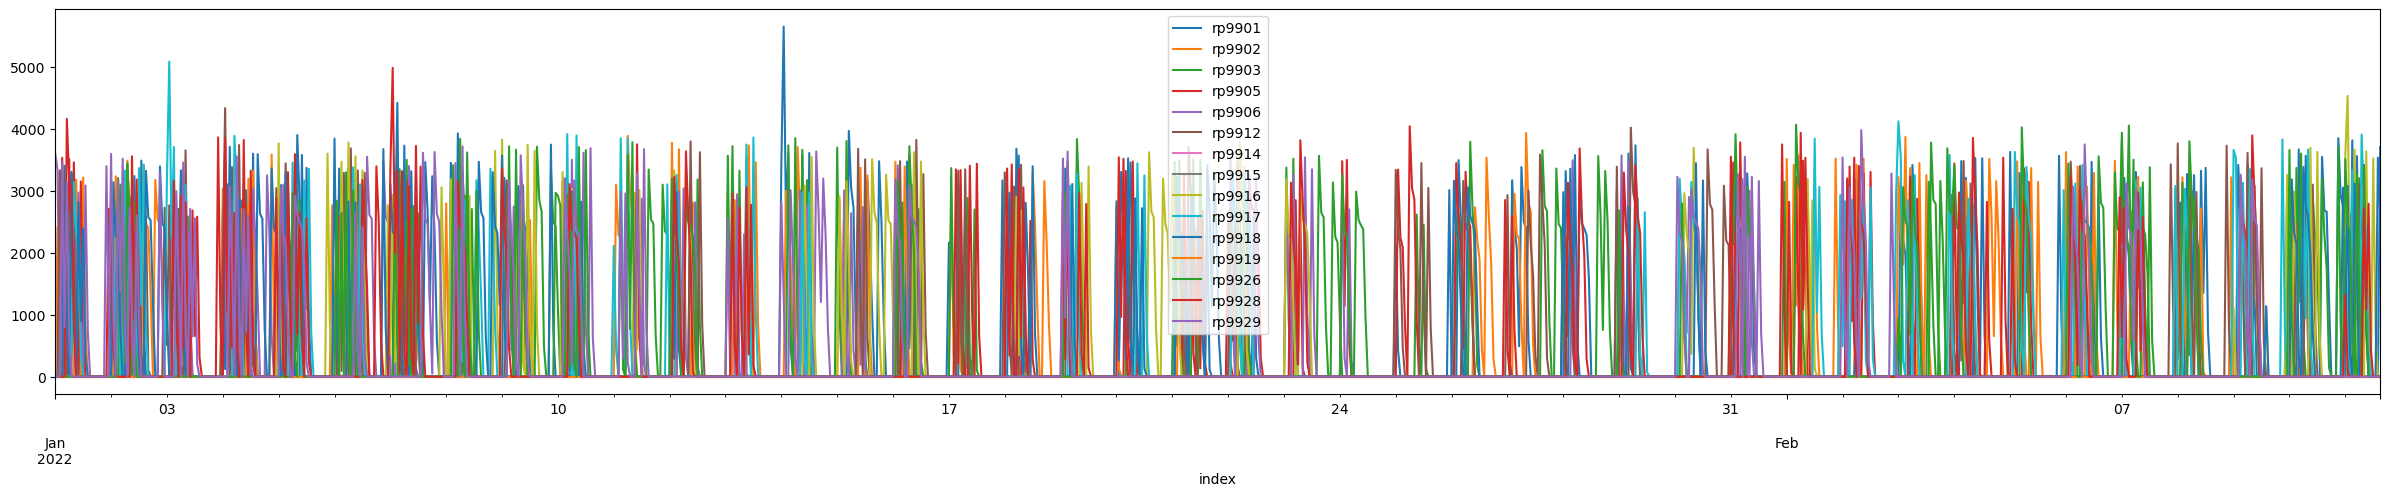

In [7]:
pala321c[:1000].plot(figsize=(30,5))
plt.show()

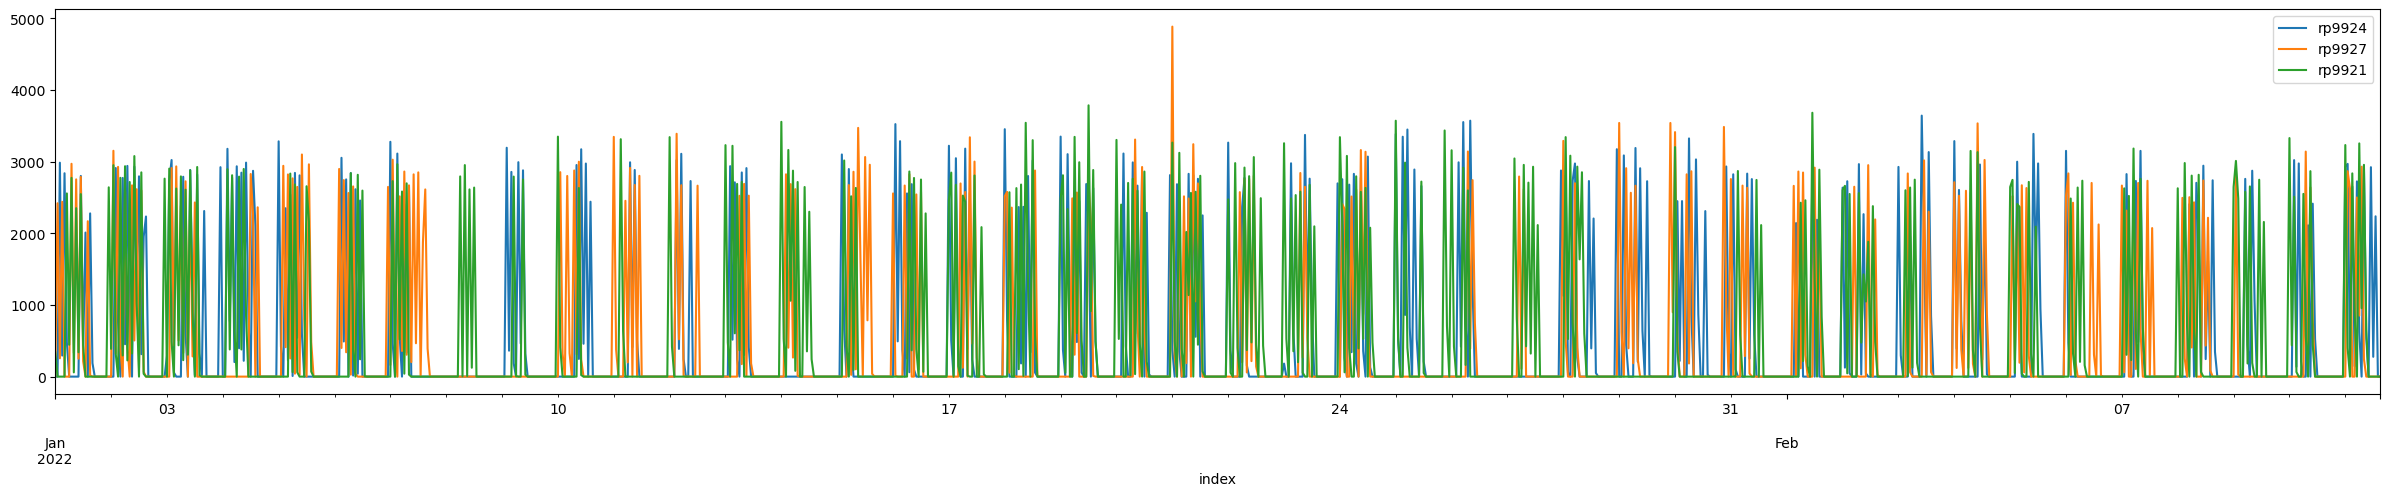

In [8]:
gapa321c[:1000].plot(figsize=(30,5))
plt.show()

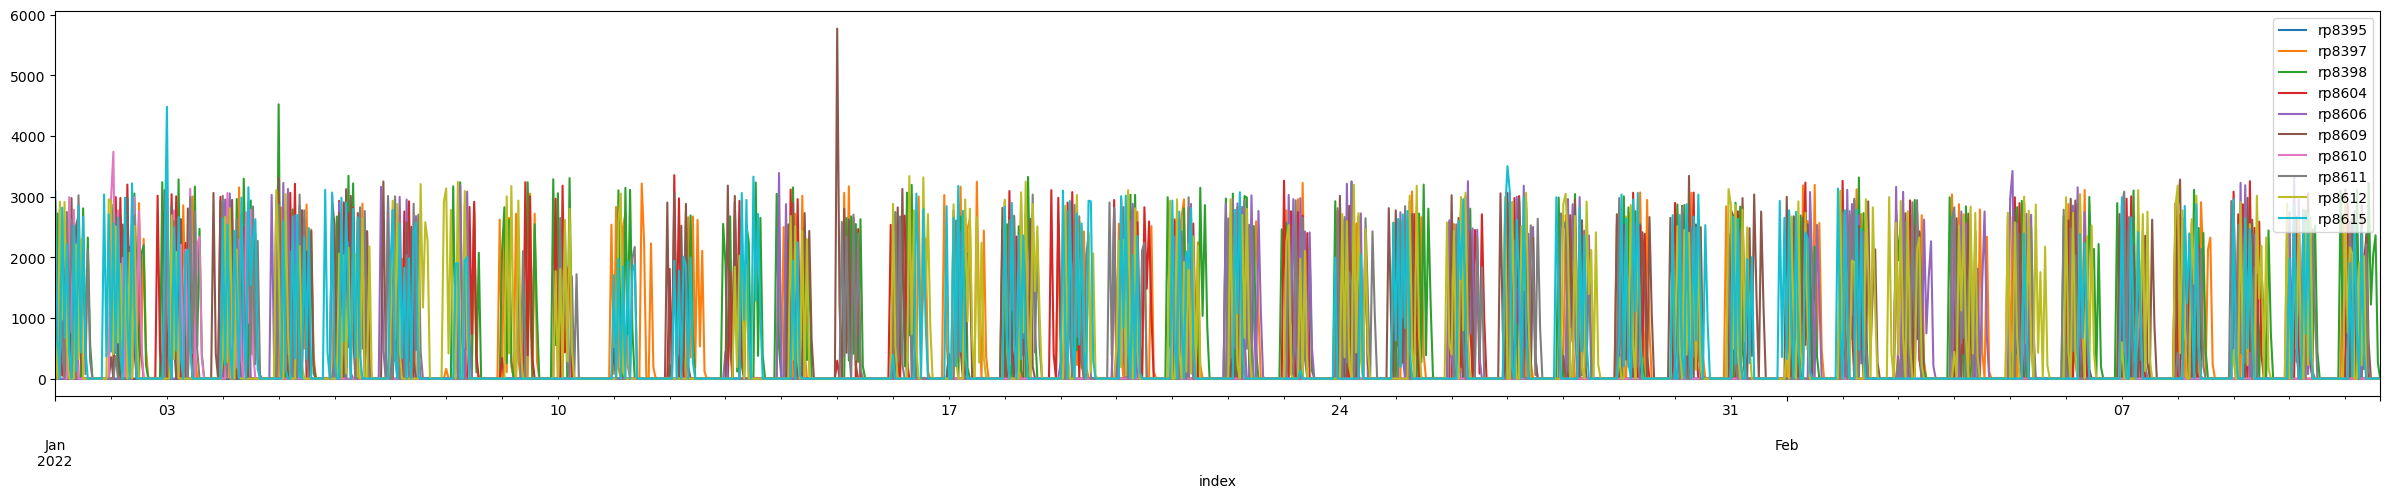

In [9]:
gapa320[:1000].plot(figsize=(30,5))
plt.show()

In [10]:
eow = {
    'palb777':297_300,
    'pala321c':106_900,
    'pala333':302_000,
    'gapa320':93_900,
    'gapa321c':106_900,
}
mtow = {
    'palb777':775_000,
    'pala321c':206_000,
    'pala333':553_000,
    'gapa320':172_000,
    'gapa321c':206_000,
}
div = input("MTOW / EOW: ").upper()
if div == 'EOW':
    palb777 /= eow['palb777']
    pala321c /= eow['pala321c']
    pala333 /= eow['pala333']
    gapa320 /= eow['gapa320']
    gapa321c /= eow['gapa321c']
elif div == 'MTOW':
    palb777 /= mtow['palb777']
    pala321c /= mtow['pala321c']
    pala333 /= mtow['pala333']
    gapa320 /= mtow['gapa320']
    gapa321c /= mtow['gapa321c']

MTOW / EOW: mtow


In [24]:
def normalize(df):
    mm = MinMaxScaler()
    col = df.columns
    index = df.index
    df = pd.DataFrame(mm.fit_transform(df))
    df.columns = col
    df.index = index
    return df
palb777 = normalize(palb777)
pala321c = normalize(pala321c)
pala333 = normalize(pala333)
gapa321c = normalize(gapa321c)
gapa320 = normalize(gapa320)

# EDA & Preprocessing

In [71]:
hist = pd.concat([palb777, pala333, gapa321c, pala321c, gapa320], axis=1).fillna(0)

In [72]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15167 entries, 2022-01-01 00:00:00 to 2023-09-24 22:00:00
Freq: H
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rp7772  15167 non-null  float64
 1   rp7773  15167 non-null  float64
 2   rp7774  15167 non-null  float64
 3   rp7775  15167 non-null  float64
 4   rp7776  15167 non-null  float64
 5   rp7777  15167 non-null  float64
 6   rp7778  15167 non-null  float64
 7   rp7779  15167 non-null  float64
 8   rp7782  15167 non-null  float64
 9   rp8780  15167 non-null  float64
 10  rp9924  15167 non-null  float64
 11  rp9927  15167 non-null  float64
 12  rp9921  15167 non-null  float64
 13  rp9901  15167 non-null  float64
 14  rp9902  15167 non-null  float64
 15  rp9903  15167 non-null  float64
 16  rp9905  15167 non-null  float64
 17  rp9906  15167 non-null  float64
 18  rp9912  15167 non-null  float64
 19  rp9914  15167 non-null  float64
 20  rp9915  15167 non-null  float

In [73]:
hist.describe()

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782,rp8780,...,rp8395,rp8397,rp8398,rp8604,rp8606,rp8609,rp8610,rp8611,rp8612,rp8615
count,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,...,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000
mean,0.191998,0.111773,0.012939,0.058615,0.071364,0.089225,0.132459,0.109192,0.074907,0.131980,...,0.043945,0.060099,0.066160,0.033341,0.046771,0.061931,0.044107,0.064002,0.065728,0.058781
std,0.213371,0.196588,0.079673,0.131842,0.155061,0.167585,0.206412,0.174976,0.117677,0.164162,...,0.126690,0.142555,0.148829,0.102905,0.128233,0.141207,0.138879,0.146005,0.147484,0.134367
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.037244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.374749,0.244901,0.000000,0.000000,0.000000,0.014473,0.355430,0.295939,0.192189,0.287562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


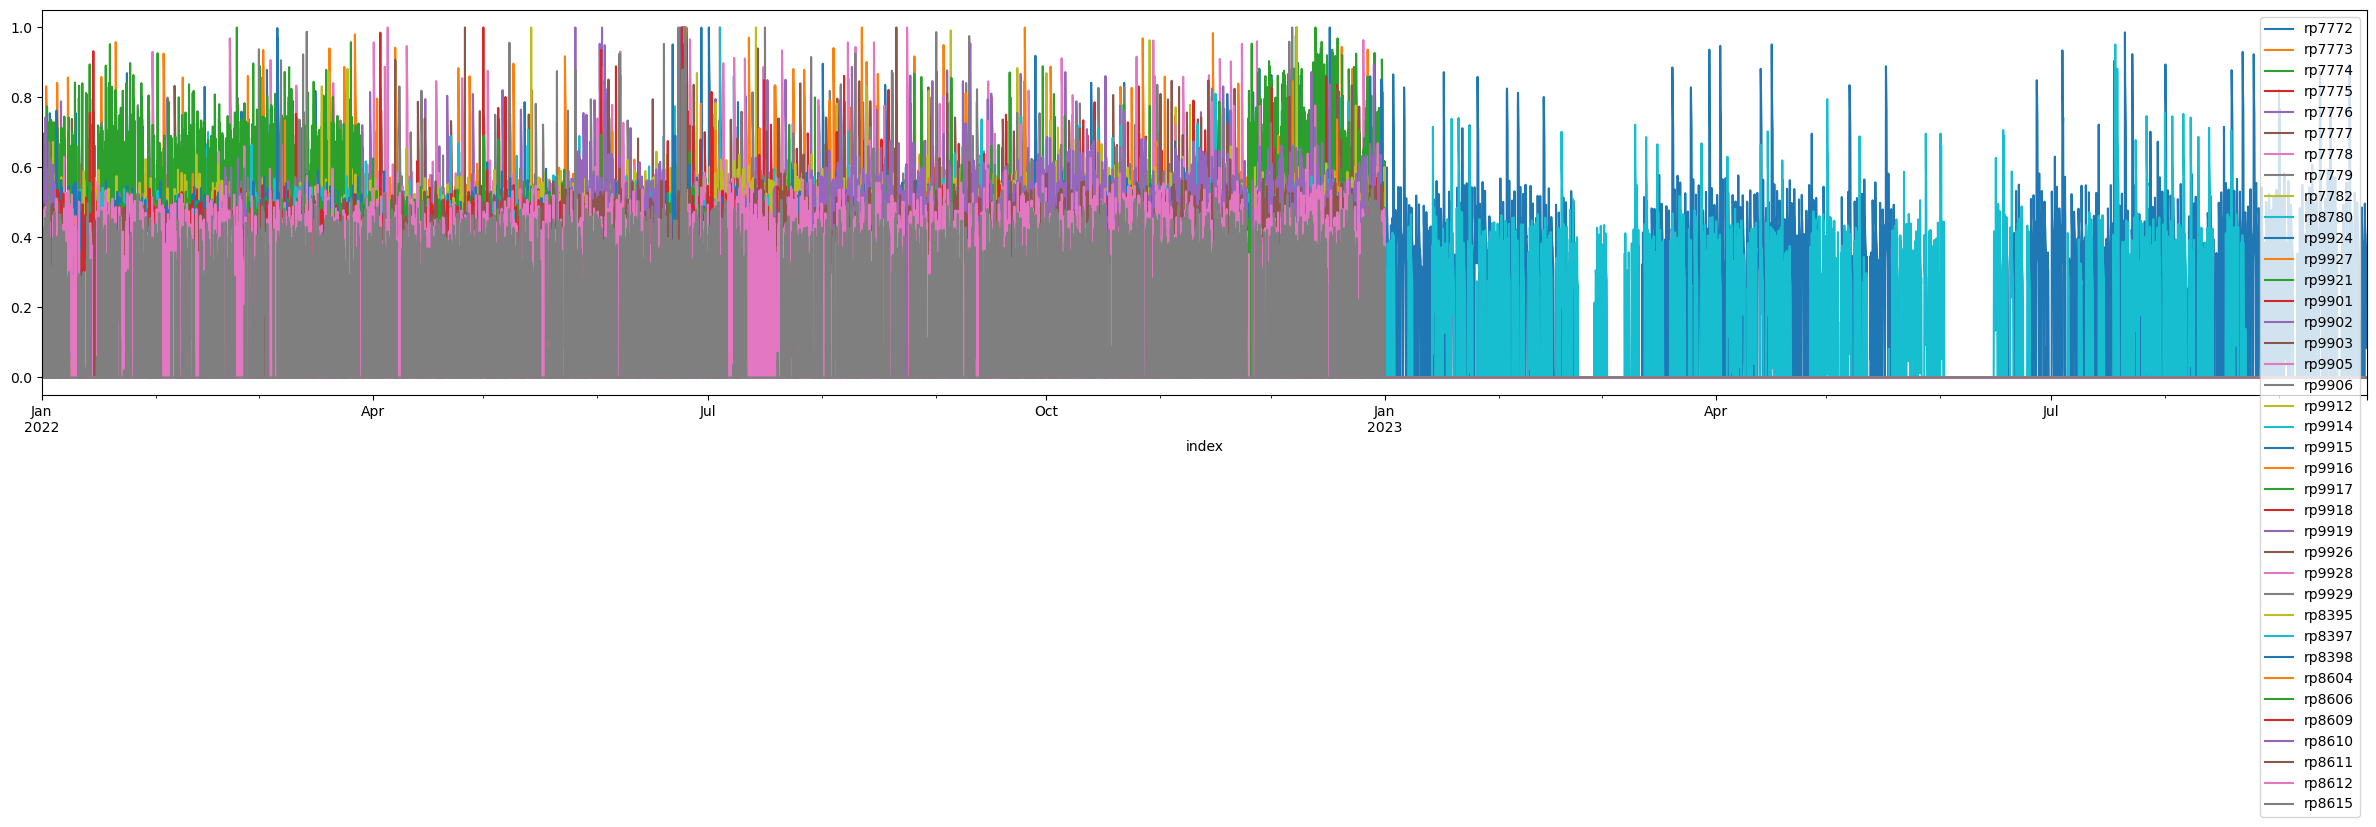

In [74]:
hist.plot(figsize=(30,5))
plt.show()

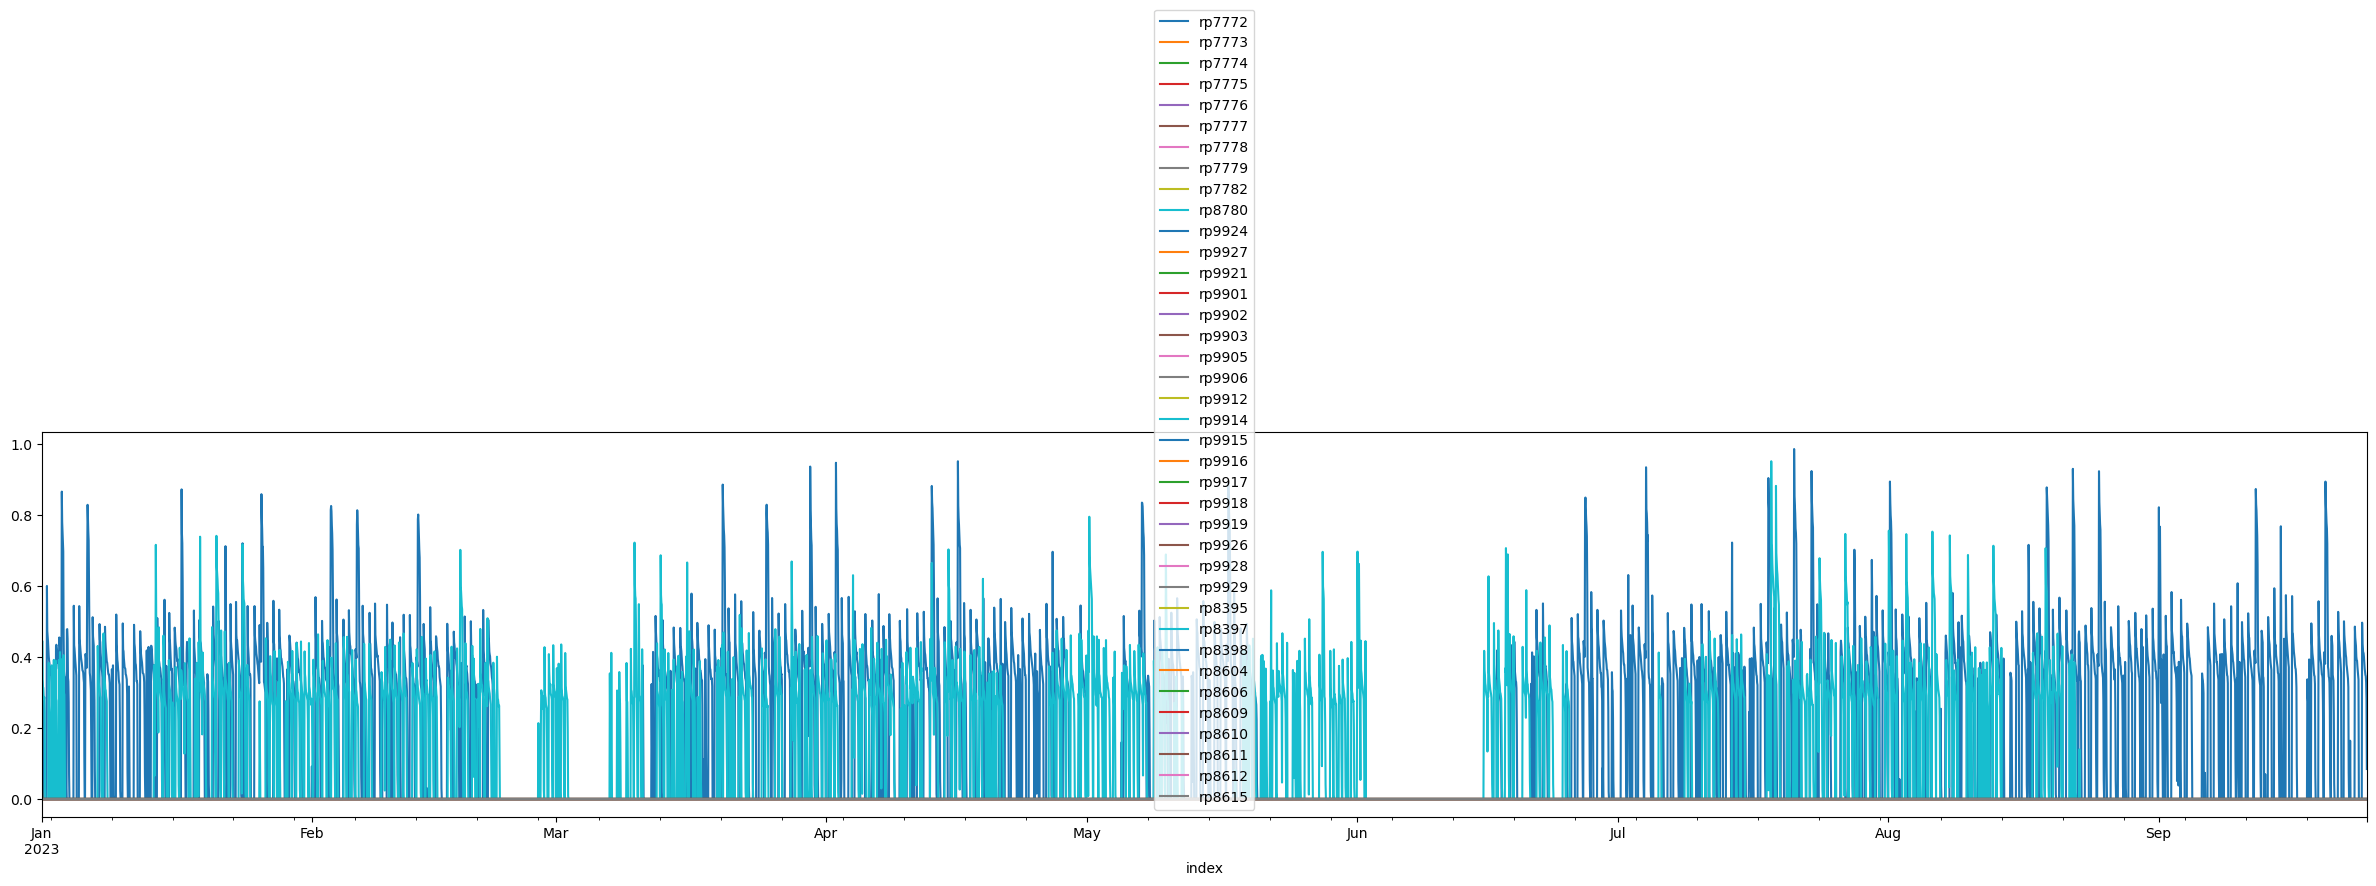

In [75]:
hist[365*24:].plot(figsize=(30,5))
plt.show()

Data Aggregation

In [76]:
agg = input("Monthly [M], Weekly [W], Daily [D], Hourly [H]: ")
agg = agg.upper()
if agg == 'W':
    agg += '-' + hist.index[1].day_name()[:3]
placeholder = hist
hist = hist.resample(agg).sum()
inc23 = input('Include year 2023 (yes - Y):')
if inc23 != 'Y':
    hist = hist[:365*24]

Monthly [M], Weekly [W], Daily [D], Hourly [H]: h
Include year 2023 (yes - Y):n


In [77]:
hist

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782,rp8780,...,rp8395,rp8397,rp8398,rp8604,rp8606,rp8609,rp8610,rp8611,rp8612,rp8615
index,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.315708,0.000000,0.000000,0.0,0.256023,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.332586,0.000000,0.000000,0.000000,0.473073,0.000000,0.000000,0.081820,0.462317
2022-01-01 01:00:00,0.160345,0.000000,0.000000,0.0,0.189050,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.422996,0.459495,0.000000,0.000000,0.107022,0.000000,0.000000,0.000000,0.098306
2022-01-01 02:00:00,0.001299,0.000000,0.000000,0.0,0.030858,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.054993,0.064670,0.317779,0.000000,0.449600,0.526434,0.405480,0.480486,0.000000
2022-01-01 03:00:00,0.375241,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.418298,0.428094,0.006705,0.000000,0.086087,0.121855,0.126197,0.160543,0.422416
2022-01-01 04:00:00,0.319114,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.077617,0.073533,0.325595,0.000000,0.000000,0.000000,0.000000,0.479841,0.101418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.279284,0.345566,0.000000,0.0,0.304799,0.318734,0.444868,0.364313,0.0,0.276621,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-12-31 20:00:00,0.000000,0.284848,0.000000,0.0,0.243470,0.320101,0.413464,0.342644,0.0,0.272546,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-12-31 21:00:00,0.000000,0.065280,0.568467,0.0,0.062444,0.304233,0.405879,0.335114,0.0,0.187033,...,0.0,0.000000,0.000000,0.000000,0.485294,0.000000,0.000000,0.466589,0.481758,0.373909


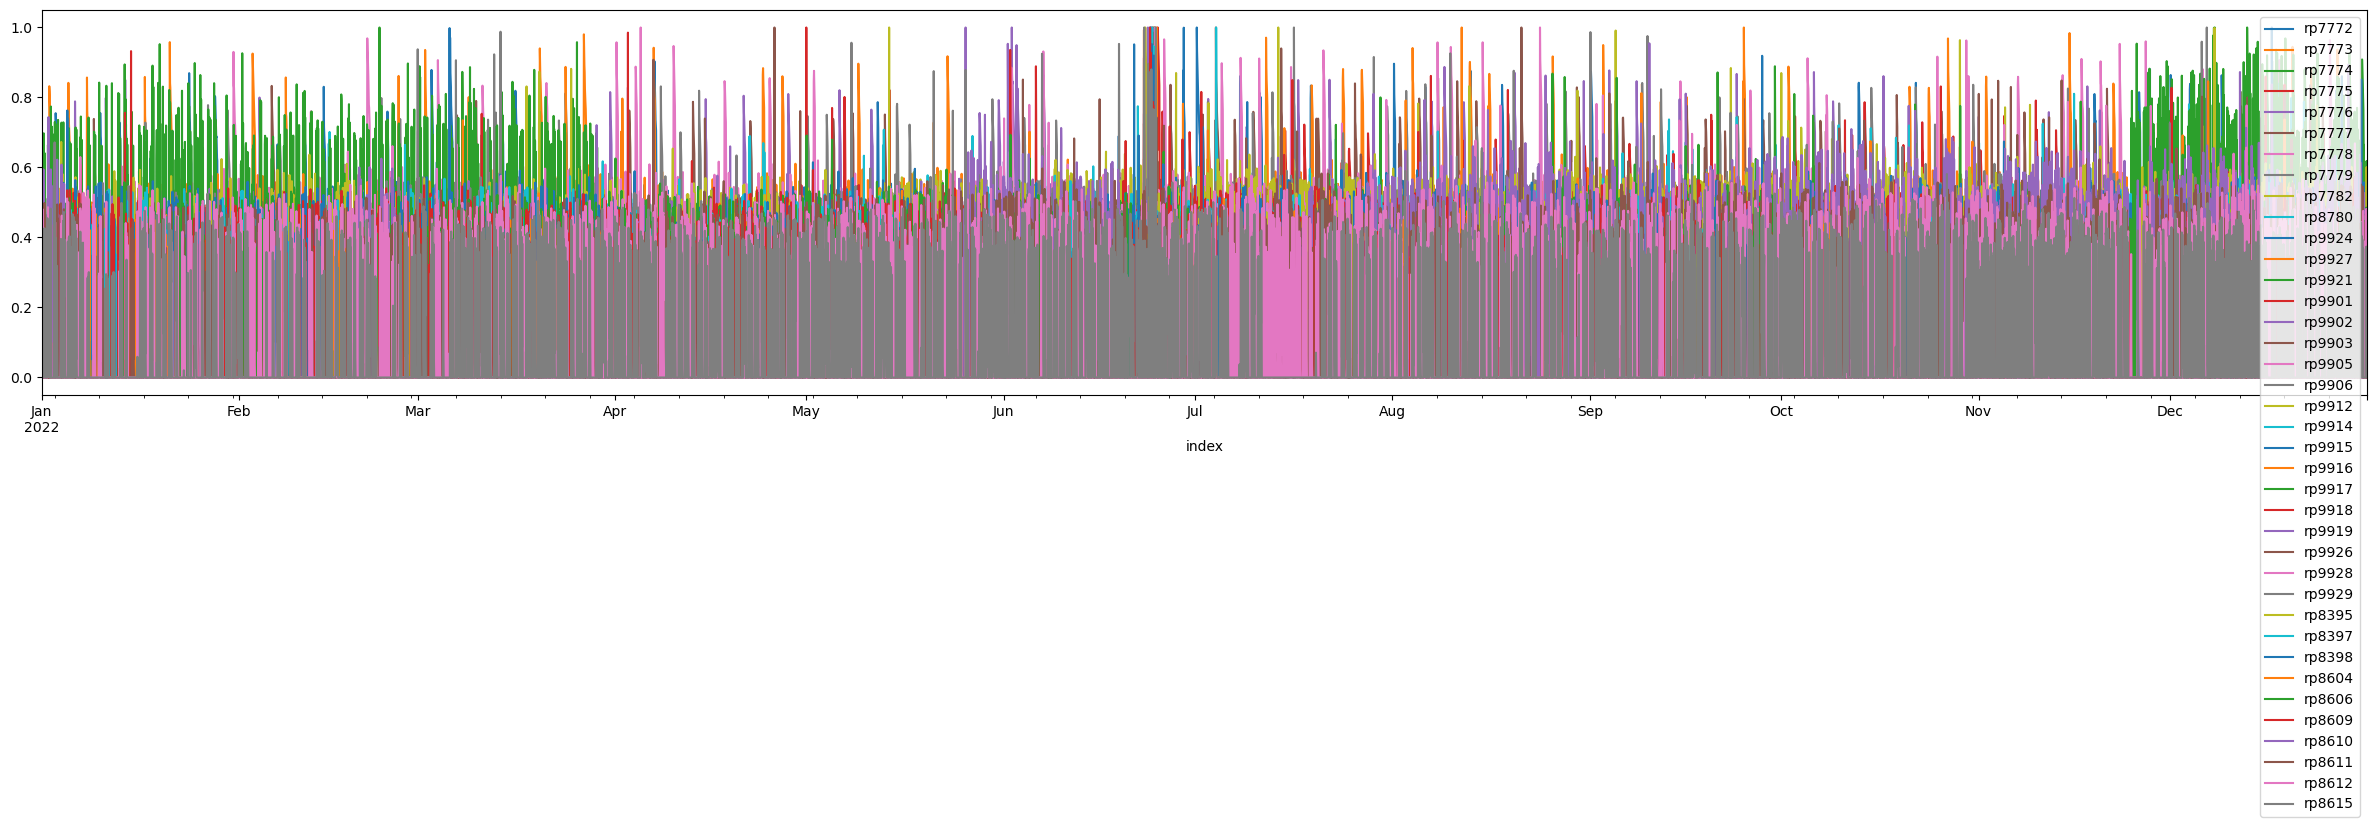

In [78]:
hist.plot(figsize=(30,5))
plt.show()

Separate the data

In [79]:
hist_list = []
for each in list(hist.columns):
    hist_list.append(hist[[each]])

Process the data

In [95]:
# ss = StandardScaler()
time_step = 408 # time step for preprocessing
pred_step = 1   # number of predictions

def time_step_prep(data, time_step,pred_step):
    X = []
    y = []
    for i in range(time_step, data.shape[0]-pred_step):
        X.append(list(data.iloc[i-time_step:i, 0].values.reshape(-1)))
        y.append(list(data.iloc[i:i+pred_step, 0].values.reshape(-1)))
    return X, y

In [81]:
X, y = np.array([[]]), np.array([[]])
for each in hist_list:
    X_n, y_n = time_step_prep(each, time_step, pred_step)
    if X.shape[1] == 0 and y.shape[1] == 0:
        X = np.array(X_n)
        y = np.array(y_n)
    else:
        X = np.concatenate([X, np.array(X_n)])
        y = np.concatenate([y, np.array(y_n)])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True)

In [83]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(299010, 16)
(299010, 1)
(33224, 16)
(33224, 1)


Standardization

In [84]:
class Scaler:
    mean = 0.0
    std = 0.0
    def fit(self, X):
        self.mean = X.mean()
        self.std = X.std()
    def transform(self, X):
        return (X - self.mean)/self.std
    def inverse(self, X):
        return (X * self.std) + self.mean

In [85]:
ss = Scaler()
ss.fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
y_train = ss.transform(y_train)
y_test = ss.transform(y_test)

Convert the data to torch

In [86]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Prediction Models

Construct Prediction Models

In [87]:
# LSTM based prediction model
class LSTM_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):        
        # forward propagate
        out, (h_,c_) = self.lstm(x)
        out = self.fc(out)
        return out
    
# RNN based prediction model
class RNN_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='relu', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        # forward propagate
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Simple Autoregressive Model
auto_reg = nn.Linear(time_step,pred_step)

# AR with Activation
auto_reg2 = nn.Sequential(
    nn.Linear(time_step, time_step // 2),
    nn.ReLU(),
    nn.Linear(time_step // 2, 1),
)

In [88]:
input_features = X_train.shape[-1]
hidden_size = 32
num_layers = 2
out_size = 1

model = LSTM_based(input_features, hidden_size, out_size, num_layers)
# model = RNN_based(input_features, hidden_size, out_size, num_layers)
# model = auto_reg
# model = auto_reg2

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# loss_fun = nn.L1Loss()
loss_fun = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.1)

In [89]:
train_loss = []
test_loss = []

def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               scheduler=None,
               epochs=500):
    
    global train_loss
    global test_loss
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred, y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
#     return train_loss, test_loss

In [90]:
train_model(
    model, 
    loss_fun,
    optimizer, 
    X_train, 
    X_test,
    y_train, 
    y_test,
    scheduler,
    1000
)

Epoch :0.005    Train Loss :1.4769508838653564    Test Loss :1.056136965751648
Epoch :0.01    Train Loss :0.8935282230377197    Test Loss :0.8574168086051941
Epoch :0.015    Train Loss :0.7842926383018494    Test Loss :0.7736266851425171
Epoch :0.02    Train Loss :0.7303533554077148    Test Loss :0.7275643348693848
Epoch :0.025    Train Loss :0.708490788936615    Test Loss :0.7063336372375488
Epoch :0.03    Train Loss :0.6892291903495789    Test Loss :0.6895493865013123
Epoch :0.035    Train Loss :0.6780659556388855    Test Loss :0.6791697144508362
Epoch :0.04    Train Loss :0.6689938306808472    Test Loss :0.6707257032394409
Epoch :0.045    Train Loss :0.6618102192878723    Test Loss :0.6653169989585876
Epoch :0.05    Train Loss :0.6552390456199646    Test Loss :0.658656120300293
Epoch :0.055    Train Loss :0.6478756666183472    Test Loss :0.652704656124115
Epoch :0.06    Train Loss :0.6420618891716003    Test Loss :0.6477434635162354
Epoch :0.065    Train Loss :0.6367109417915344    

Epoch :0.525    Train Loss :0.5475962162017822    Test Loss :0.6030736565589905
Epoch :0.53    Train Loss :0.5439496636390686    Test Loss :0.6032485961914062
Epoch :0.535    Train Loss :0.5480121970176697    Test Loss :0.6026748418807983
Epoch :0.54    Train Loss :0.5425312519073486    Test Loss :0.6003130674362183
Epoch :0.545    Train Loss :0.54643714427948    Test Loss :0.6050609350204468
Epoch :0.55    Train Loss :0.5421952605247498    Test Loss :0.6050655841827393
Epoch :0.555    Train Loss :0.5455194711685181    Test Loss :0.6024761199951172
Epoch :0.56    Train Loss :0.5399816632270813    Test Loss :0.601223349571228
Epoch :0.565    Train Loss :0.546053409576416    Test Loss :0.6126584410667419
Epoch :0.57    Train Loss :0.539402186870575    Test Loss :0.6043715476989746
Epoch :0.575    Train Loss :0.5429515242576599    Test Loss :0.6018447875976562
Epoch :0.58    Train Loss :0.5428329110145569    Test Loss :0.6041598320007324
Epoch :0.585    Train Loss :0.5382707118988037    T

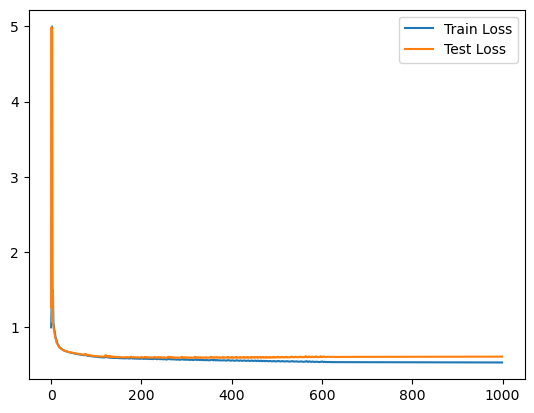

In [91]:
ax = plt.subplot()
ax.plot(train_loss, label='Train Loss')
ax.plot(test_loss, label='Test Loss')
ax.legend()

Single-step prediction

In [45]:
actual = pd.DataFrame(ss.inverse(y_test.detach().numpy().reshape(-1,1))).rename({0:'actual'},axis=1)
pred = pd.DataFrame(ss.inverse(model(X_test).detach().numpy())).rename({0:'single_pred'},axis=1)

NameError: name 'ss' is not defined

In [92]:
actual = pd.DataFrame(y_test.detach().numpy().reshape(-1,1)).rename({0:'actual'}, axis=1)
pred = pd.DataFrame(model(X_test).detach().numpy()).rename({0:'single_pred'},axis=1)

<Axes: >

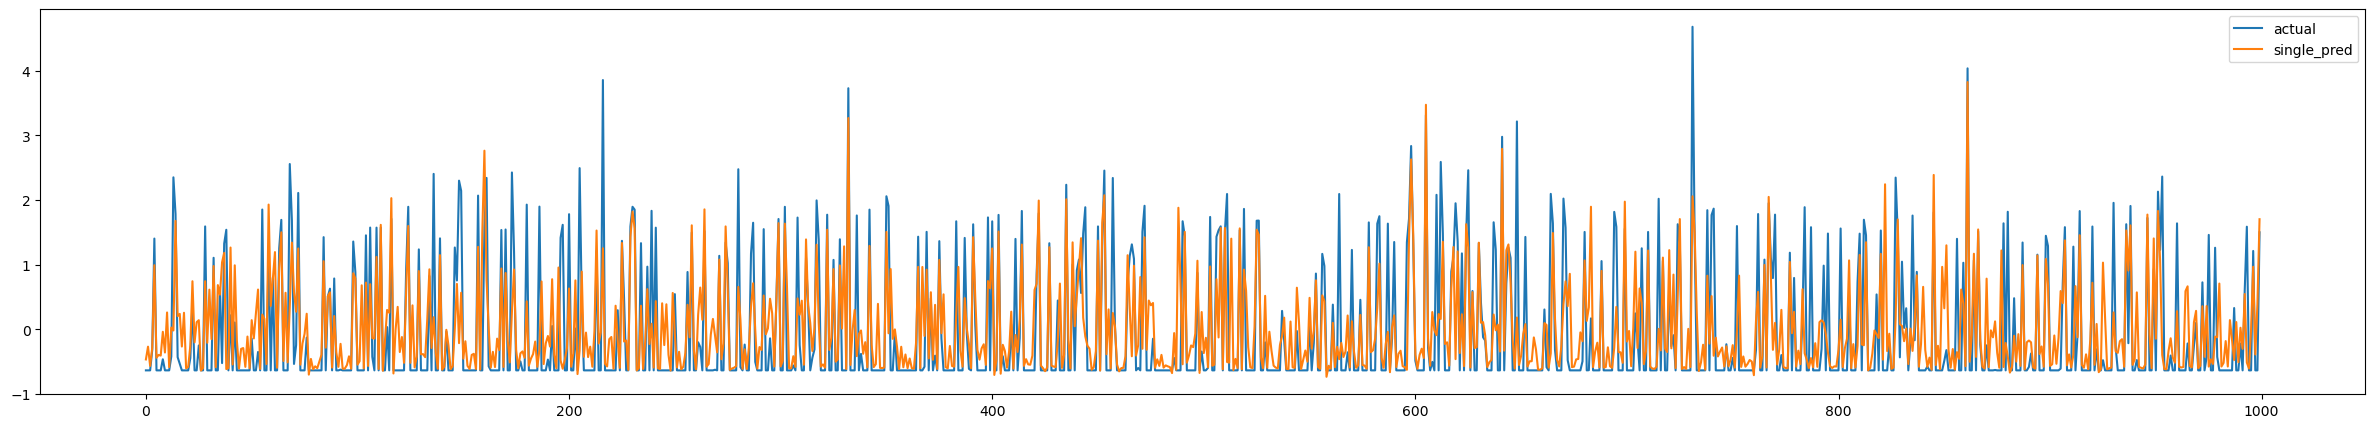

In [93]:
actual_pred = pd.concat([actual, pred], axis=1)
actual_pred[:1000].plot(figsize=(30,5))

In [94]:
rmse = float(np.sqrt(sum((actual.values - pred.values)**2)/len(actual)))
r2 = r2_score(actual, pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.7803582549095154
R2: 0.39276116127358207


Recursive-step prediction

In [70]:
def recursive_step(i, pred_step, plot=True, ret='total', denorm=True):
    multi_pred = []
    currX = X_test[i]
    
    while len(multi_pred) != pred_step:
        tensor_pred = model(currX)
        currX = torch.cat([currX, tensor_pred])
        currX = currX[-time_step:]
        pred = ss.inverse(tensor_pred.detach().numpy().reshape(-1,1))
        multi_pred.append(float(pred))
    
    actual = y_test[i:i+pred_step].detach().numpy()
    multi_pred = np.array(multi_pred).reshape(-1,1)
    if denorm:
        actual = ss.inverse(actual)
    else:
        multi_pred = ss.transform(multi_pred)
    df = pd.DataFrame(np.concatenate([actual,multi_pred], axis=1)).rename({0:'actual',1:'single_rec'}, axis=1)
    total = df.sum().reset_index().T
    total.columns = total.loc['index']
    total.drop('index', inplace=True)
    total.rename({0:i}, inplace=True)
    if plot:
        df.plot()
    if ret == 'total':
        return total
    elif ret == 'frame':
        return df

In [ ]:
i = 0
data = pd.DataFrame()
while True:
    try: 
        df = recursive_step(i, 168, False)
        print(i)
        data = pd.concat([data, df])
        i += 1
        clear_output(wait=True)
    except:
        print('STOP')
        break

In [ ]:
data

In [ ]:
r2_score(data['actual'], data['single_rec'])

In [ ]:
data.plot(figsize=(30,5))

For multiple output models

In [ ]:
def multi_step(i, plot=True, ret='total', denorm=True):
    if denorm:
        actual = ss.inverse(y_test[i].detach().numpy().reshape(-1,1))
        pred = ss.inverse(model(X_test[i]).detach().numpy().reshape(-1,1))
    else:
        actual = y_test[i].detach().numpy().reshape(-1,1)
        pred = model(X_test[i]).detach().numpy().reshape(-1,1)
    df = pd.DataFrame(np.concatenate([actual, pred], axis=1)).rename({0:'actual', 1:'pred'}, axis=1)
    total = df.sum().reset_index().T
    total.columns = total.loc['index']
    total.drop('index', inplace=True)
    total.rename({0:i}, inplace=True)
    if plot:
        df.plot()
    if ret == 'total':
        return total
    elif ret == 'frame':
        return df

In [ ]:
multi_step(700, ret='frame', denorm=True)

In [ ]:
i = 0
data = pd.DataFrame()
while True:
    try: 
        df = multi_step(i, False)
        print(i)
        data = pd.concat([data, df])
        i += 1
        clear_output(wait=True)
    except:
        print('STOP')
        break

In [ ]:
data

In [ ]:
r2_score(data['actual'], data['pred'])

In [ ]:
data.plot(figsize=(30,5))

# Save/Load Model

In [ ]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
torch.save(auto_reg, directory + filename + '.pt')

In [ ]:
directory = input('Directory to load the model: ')
filename = input('Model Name: ')
load_mod = torch.load(directory + filename + '.pt')
model = load_mod
model.eval()

In [ ]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print(layer.state_dict()['weight'])
        print(layer.state_dict()['bias'])

In [ ]:
for layer in model.children():
    print(layer)

In [ ]:
model.weight.data